# Image Captioning using Visual Attention

## Importing Libraries

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import collections
import random
import time
import json
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization



seed = 111
np.random.seed(seed)
tf.random.set_seed(seed)

## Donwloading the Flicker8k dataset, with the images and captions

In [ ]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

replace Flicker8k_Dataset/1000268201_693b08cb0e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace CrowdFlowerAnnotations.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Config

In [ ]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True, log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7



## Defining Constants

In [ ]:
# Path to the images
IMAGES_PATH = "Flicker8k_Dataset"

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
MAX_SEQ_LENGTH = 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

## Preprocessing

### Combining captions with respective image

In [ ]:
def caption_images(filename):
    """ Reads the caption data from txt file and maps it to correspondent image
    
    Arguments:
        filename: Path to caption data txt file.
    
    Returns:
        caption_map: Dictionary with the mapping image:captions
        text: List containing all used captions
    """
    with open(filename) as captions:
        # Images to not use
        images_skip = set()
        # caption data
        caption_data = captions.readlines()
        # the caption-image mapping
        caption_map = {}
        # The text data
        text = []
        
        for line in caption_data:
            # Remove end of line
            line = line.rstrip("\n")
            # image name and caption are separated by a tab on txt file
            name,caption = line.split("\t")
            
            # Each image is repeated for each of the 5 captions, and has a suffix #caption_number
            name = name.split("#")[0]
            name = os.path.join(IMAGES_PATH, name.strip())
            
            
            tokens = caption.strip().split()
            
            # We won't use too short or too long captions
            if len(tokens) < 5 or len(tokens) > MAX_SEQ_LENGTH:
                images_skip.add(name)
                continue
                
            # Mapping images we want 
            if name.endswith("jpg") and name not in images_skip:
                # Adding start and end tokens and adding it to the text list
                caption = "<start>" + caption.strip() + "<end>"
                text.append(caption)
                
                # Mapping image to captions
                if name in caption_map:
                    caption_map[name].append(caption)
                else:
                    caption_map[name] = [caption]
        # Removing not wanted images
        for name in images_skip:
            if name in caption_map:
                del caption_map[name]
                
        return caption_map, text
                
                

### Splitting the dataset between training and validation sets

In [ ]:
def dataset_split(captions, train_percent=0.8, shuffle=True):
    
    # List of all image names
    images = list(captions.keys())
    
    # Shuffle
    if shuffle:
        np.random.shuffle(images)
    
    #Define training dataset size
    train_size = int(len(captions)* train_percent)
    
    # Splitting the data
    train_split = {
        name: captions[name] for name in images[:train_size]
    }
    val_split = {
        name: captions[name] for name in images[train_size:]
    }
    
    return train_split,val_split

### Getting the caption-image mapping and the captions themselves



In [ ]:
caption_map, text = caption_images("Flickr8k.token.txt")

### Dividing into train and validation sets

In [ ]:
atrain,val = dataset_split(caption_map)

In [ ]:
len(train)

6114

In [ ]:
len(val)

1529

### Standardization on the caption text
Removing special characters expect for "<>" because of the start and end tokens and creaitng a TextVectorization layer for the inputs

In [ ]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

# removing these characters from text
strip_chars = "!\"#$%&'()*+,-./:;=?@[\]^_`{|}~"

# Vectorizing text data
vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)

### Function that decodes and resizes images using tf.io

In [ ]:
def read_and_transform(img_path):
    img = tf.io.read_file(img_path)
    # decoding image
    img = tf.image.decode_jpeg(img, channels=3)
    # resizing image
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

### Function that returns the processed images and captions in pair

In [ ]:
def processing(img_path,captions):
    return read_and_transform(img_path), vectorization(captions)

### Creating the tf.data.Dataset for faster processing

In [ ]:
def create_dataset(images, captions):
    # Creates dataset, shuffles it and batches it (optimized using AUTOTUNE)
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(len(images))
    dataset = dataset.map(processing, num_parallel_calls = AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    
    return dataset

### Getting the tf.data version of both the train and validation datasets

In [ ]:
train_dataset = create_dataset(list(train.keys()), list(train.values()))
val_dataset = create_dataset(list(val.keys()), list(val.values()))

## Defining the Model

### CNN for retrieving important features from the image, which it will then be fed to the transformer model

Specific Model used was [EfficentNetB0](https://arxiv.org/abs/1905.11946v5) 

In [ ]:
def cnn():
    base = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
    )
    
    base.trainable = False
    base_out = base.output
    base_out = layers.Reshape((-1, base_out.shape[-1]))(base_out)
    cnn_model = keras.models.Model(base.input,base_out)
    return cnn_model

### The transformer
The transformer model used was based on the original architecture from the now classic paper [Attention is All you Need](https://arxiv.org/abs/1706.03762)
The main building blocks of the transformer model are the self-attention layers which receive a input of word embeddings and outputs how much a certain word is related to another on the input (this is learned by the model and depends on the task at hand).
The encoder block is then responsible for mapping an input sequence into an abstract continuous representation
And the decoder then takes that continuous representation and step by step generates a single output while also being fed the previous output.
Lastly the Positional Embedding is responsible for encoding the absolute position of a word in a sentence, without that the transformer would not know that valuable information.

For a more thorough explanation read this great article by Peter Bloem [Transformers from scratch](http://peterbloem.nl/blog/transformers)

### Transformer Encoder block

In [ ]:
class Encoder(layers.Layer):
    # Defining encoder parameters and layers following original Transformer architecture
    def __init__(self,embed_dim,dense_dim,num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim = embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation= "relu")
    
    # call function defining connections between the layers
    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)
        
        attention_output_1 = self.attention_1(
            query = inputs,
            value = inputs,
            key = inputs,
            attention_mask = None,
            training=training
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1

### Positional Embedding class defines positional embedding layer

In [ ]:
class PositionalEmbedding(layers.Layer):
    # Defining positional embedding parameters
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))
    
    # embedding the actual tokens to add positional data
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

### Transformer Decoder block

In [ ]:
class Decoder(layers.Layer):
    # Defining parameters and layers of the block following original transformer architecture
    def __init__(self,embed_dim,ff_dim,num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)
        
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        
        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=MAX_SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")
        
        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True
    
    # defining connection between layers and adding padding mask
    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds
    
    # defining mask so the decoder doesn't look into the future
    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

### Defining the complete model

In [ ]:
class ImageCaptioningModel(keras.Model):

    # defining parameters and blocks(cnn->encoder->decoder)
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug
    
    # calculate loss function for prediction on valid tokens(defined using mask)
    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)
    
    #calculate accuracy of the model predictions
    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)
    
    # compute both loss and accuracy given model output
    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc
    
    # training step
    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}
    
    # test_step
    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]  

## Training the model

### Instantiating all blocks and full model

In [ ]:
cnn_model = cnn()
encoder = Encoder(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=4)
decoder = Decoder(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=5)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

### Defining loss and early stopping routine

In [ ]:
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


### Defining and instantiating Learning Rate Scheduler with warmup 

In [ ]:
# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

### Compiling and training the model

In [ ]:
# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Fit the model
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping],
)

Epoch 1/30
96/96 [==============================] - 249s 2s/step - loss: 29.1837 - acc: 0.1023 - val_loss: 21.4699 - val_acc: 0.2848
Epoch 2/30
96/96 [==============================] - 209s 2s/step - loss: 20.2899 - acc: 0.2948 - val_loss: 18.8503 - val_acc: 0.3286
Epoch 3/30
96/96 [==============================] - 209s 2s/step - loss: 18.2189 - acc: 0.3335 - val_loss: 17.7642 - val_acc: 0.3489
Epoch 4/30
96/96 [==============================] - 226s 2s/step - loss: 16.9712 - acc: 0.3566 - val_loss: 17.0166 - val_acc: 0.3624
Epoch 5/30
96/96 [==============================] - 209s 2s/step - loss: 16.0647 - acc: 0.3771 - val_loss: 16.4978 - val_acc: 0.3728
Epoch 6/30
96/96 [==============================] - 226s 2s/step - loss: 15.3279 - acc: 0.3915 - val_loss: 16.2087 - val_acc: 0.3802
Epoch 7/30
96/96 [==============================] - 226s 2s/step - loss: 14.6981 - acc: 0.4058 - val_loss: 15.9729 - val_acc: 0.3851
Epoch 8/30
96/96 [==============================] - 227s 2s/step - lo

## Checking captioning capabilities

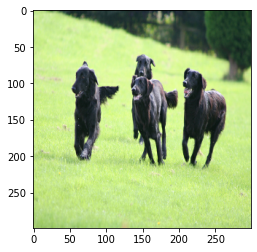

Predicted Caption:  dogs run through the grass


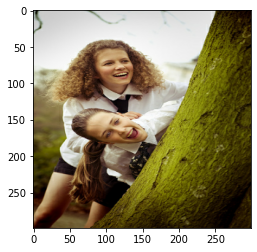

Predicted Caption:  girls are sitting on a rock face of hay


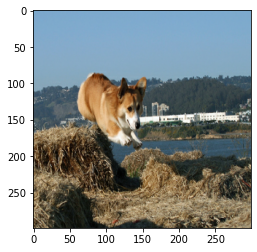

Predicted Caption:  dog is walking through a field of tall grass water


In [ ]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = MAX_SEQ_LENGTH - 1
valid_images = list(val.keys())


def generate_caption():
    # Select a random image from the validation dataset
    sample_img = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = read_and_transform(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == " <end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()

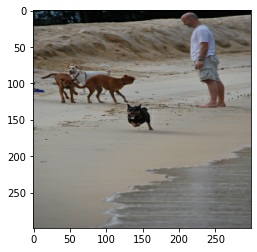

Predicted Caption:  dog is running on the beach


In [ ]:
generate_caption()

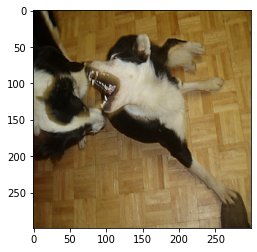

Predicted Caption:  dog is laying on its hind legs with a white dog


In [ ]:
generate_caption()